In [1]:
from typing import Dict
from pathlib import Path
from text2sql_lib.result_metrics import LLMResultMetrics
from complexity_map import complexity_map
# ---------------------------------------------------------------------------
# create one metrics object per file
# ---------------------------------------------------------------------------
BENCH_DIR           = Path("better_benchmarks")
_SUFFIX             = ".jsonl"                 # all files end with this
metrics: Dict[str, LLMResultMetrics] = {}

for json_file in sorted(BENCH_DIR.glob(f"*{_SUFFIX}")):
    model_name  = json_file.stem                         # e.g. deepseek-r1-14b
    var_name    = model_name.replace("-", "_")           # python-valid identifier
    m           = LLMResultMetrics.from_jsonl(
        json_file,
        model_name=model_name,
        complexity_map=complexity_map,
    )
    metrics[var_name] = m
    globals()[var_name] = m     # optional: create variable in global scope

metrics["gpt_4.1"].open_source=False
metrics["gpt_4.1_mini"].open_source=False
metrics["gpt_4.1_nano"].open_source=False
metrics["o3"].open_source=False
metrics["o3"].reasoning=True
metrics["o3_mini"].open_source=False
metrics["o3_mini"].reasoning=True
metrics["o4_mini"].open_source=False
metrics["o4_mini"].reasoning=True
metrics["qwen3_14b"].reasoning=True
metrics["deepseek_r1_14b"].reasoning=True

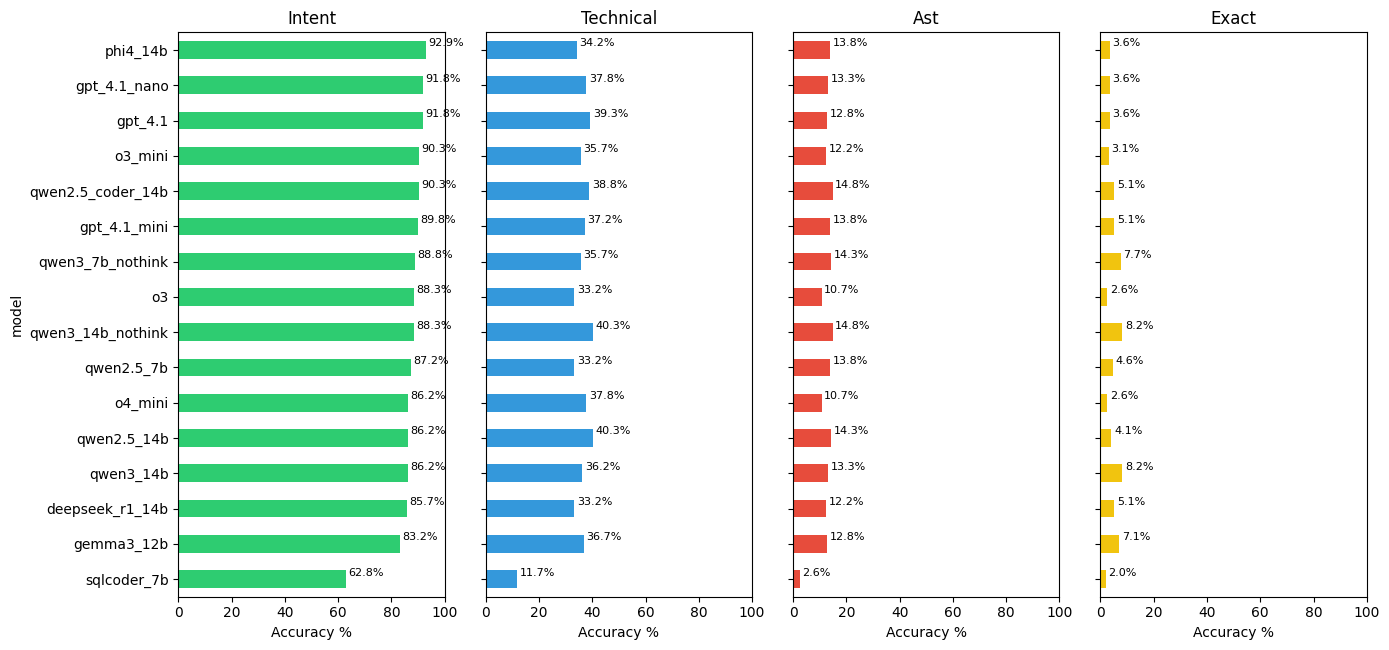

In [2]:
from text2sql_lib.viz_toolbox import plot_overall_multi, plot_difficulty_grouped, plot_superior, plot_difficulty_multi_metrics, plot_token_usage

plot_overall_multi(metrics)

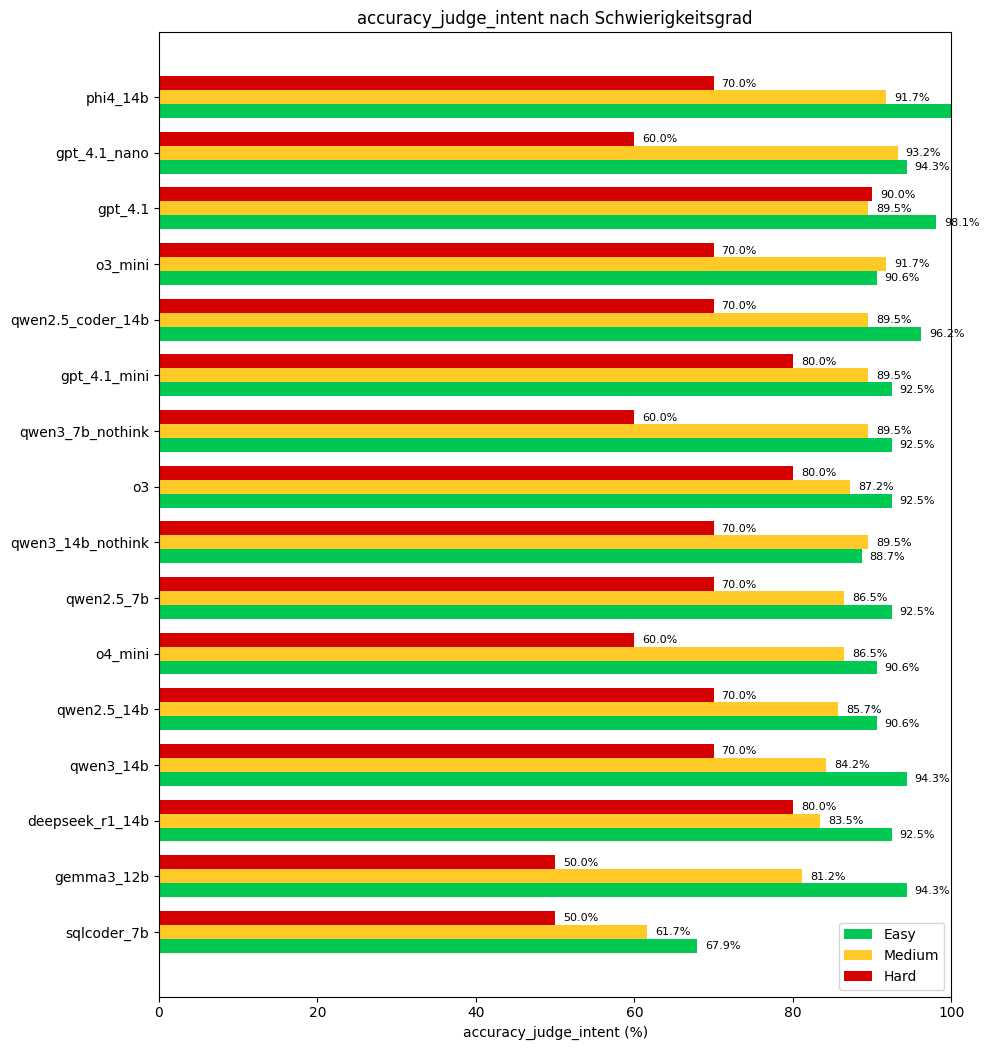

In [3]:
plot_difficulty_grouped(metrics, metric_fn_name="accuracy_judge_intent")

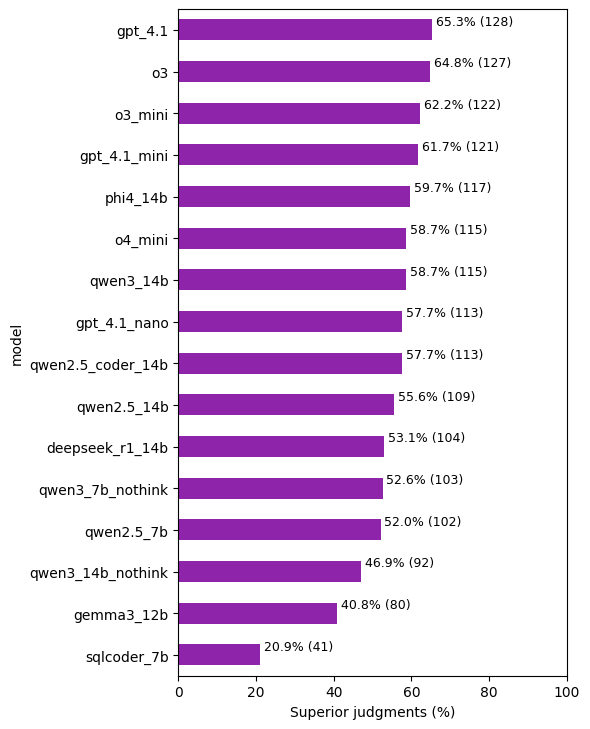

In [4]:
plot_superior(metrics, show_counts=True)

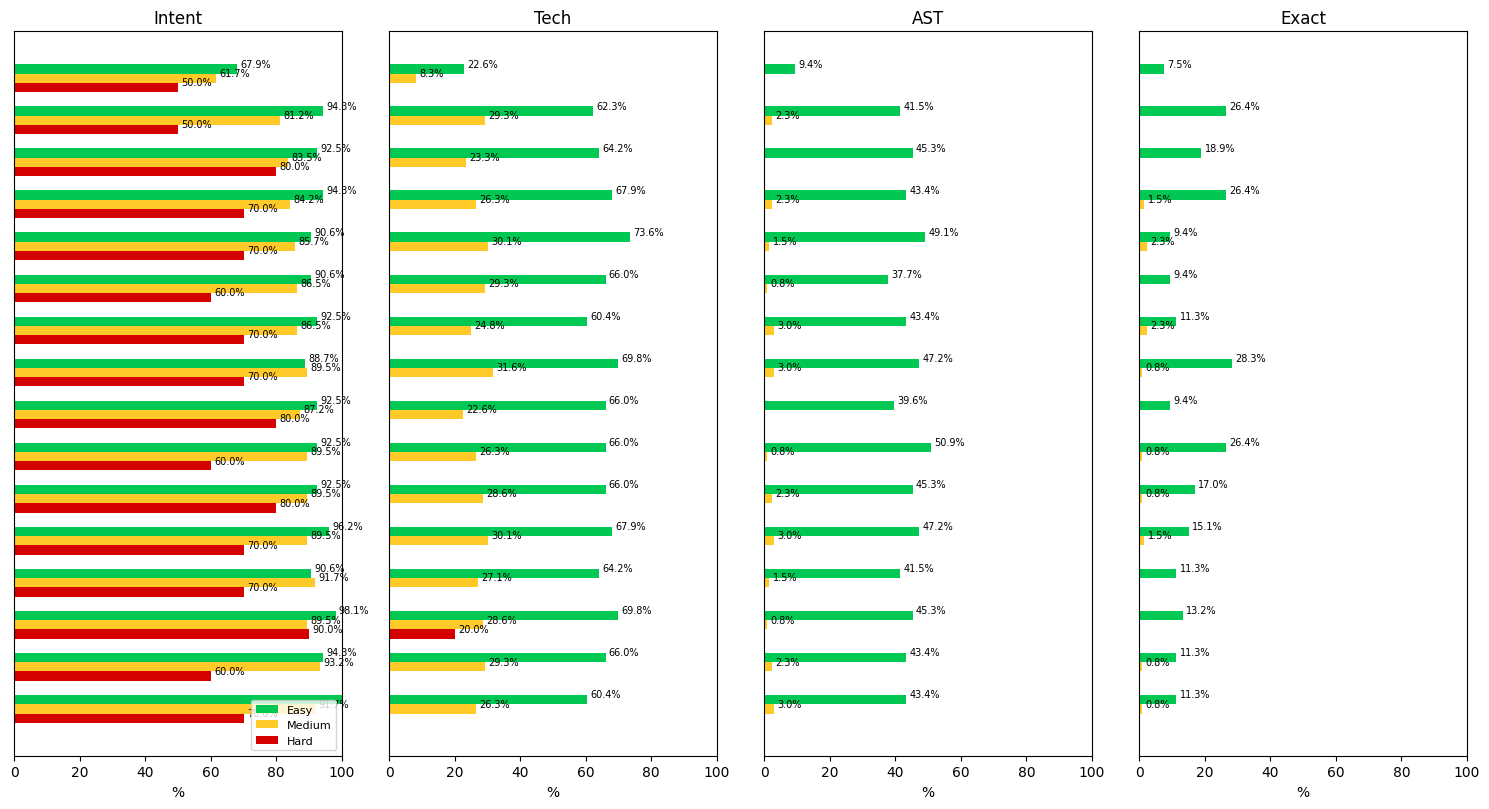

In [5]:
plot_difficulty_multi_metrics(metrics)

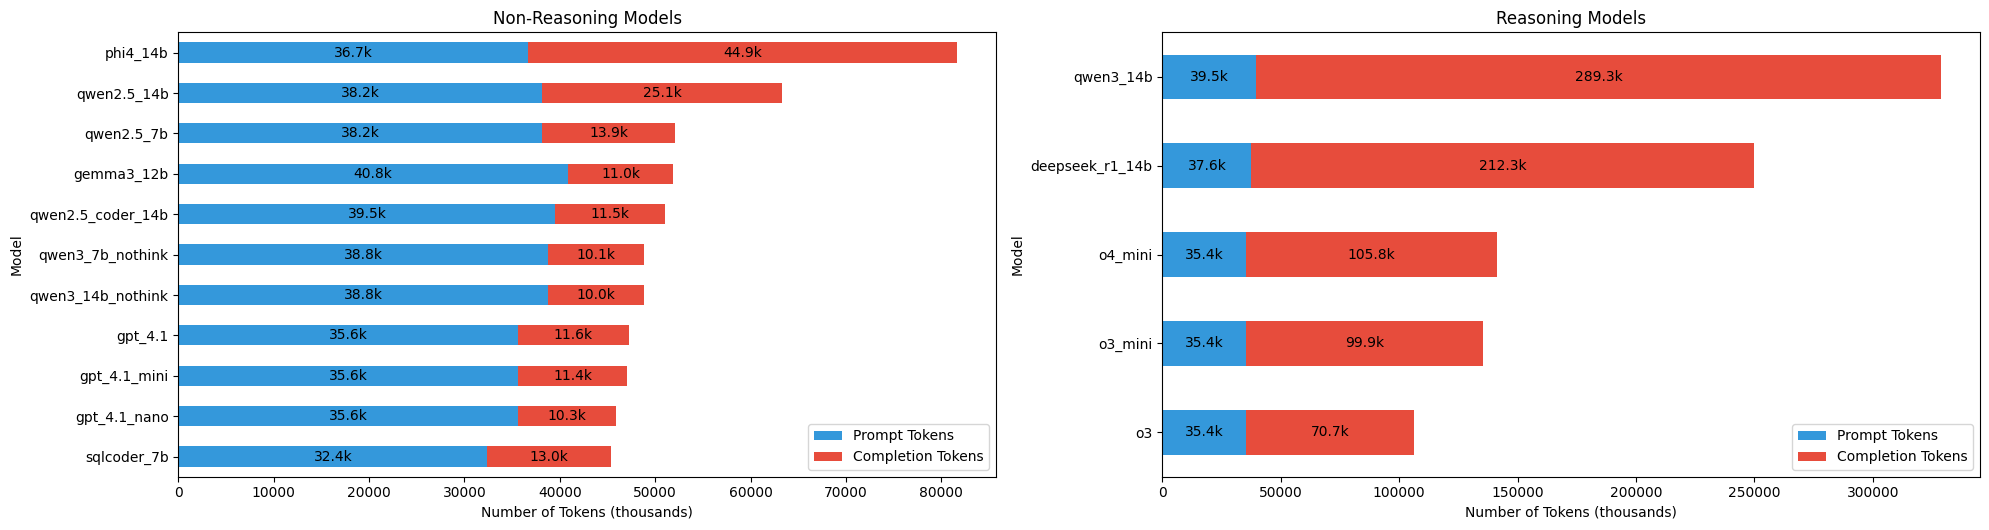

In [6]:
plot_token_usage(metrics)

<Figure size 1500x800 with 0 Axes>

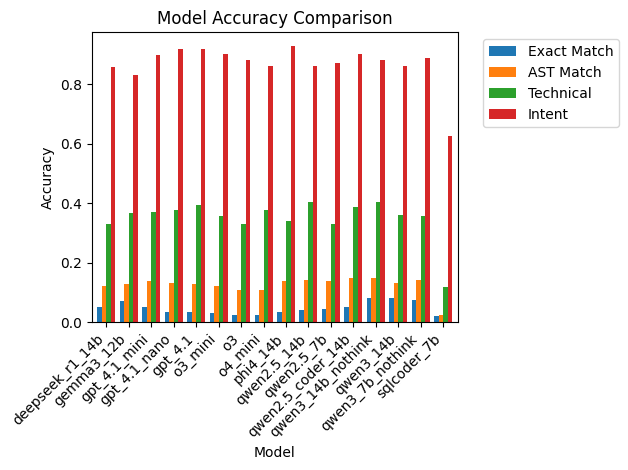

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame with accuracy metrics
accuracy_data = pd.DataFrame([
    {
        'Model': model_name,
        'Exact Match': metrics[model_name].accuracy_exact(),
        'AST Match': metrics[model_name].accuracy_ast(),
        'Technical': metrics[model_name].accuracy_judge_technical(),
        'Intent': metrics[model_name].accuracy_judge_intent()
    }
    for model_name in metrics.keys()
])

# Plot
plt.figure(figsize=(15, 8))
accuracy_data.set_index('Model').plot(kind='bar', width=0.8)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

<Figure size 1500x800 with 0 Axes>

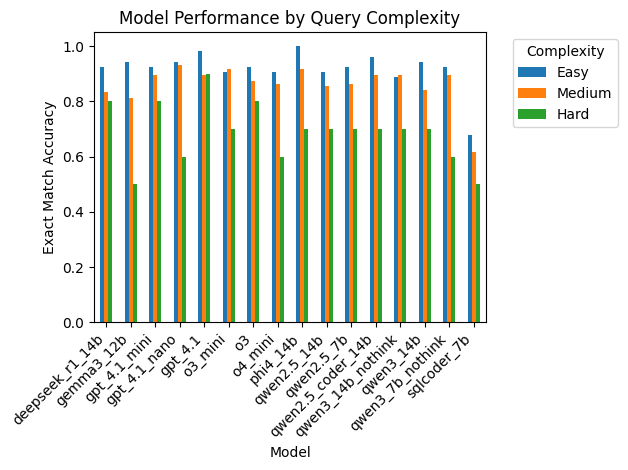

In [8]:
# Create DataFrame for complexity analysis
complexity_data = []
for model_name in metrics.keys():
    model = metrics[model_name]
    complexity_data.append({
        'Model': model_name,
        'Easy': model.accuracy_judge_intent('easy'),
        'Medium': model.accuracy_judge_intent('medium'),
        'Hard': model.accuracy_judge_intent('hard')
    })

complexity_df = pd.DataFrame(complexity_data)

# Plot
plt.figure(figsize=(15, 8))
complexity_df.set_index('Model').plot(kind='bar')
plt.title('Model Performance by Query Complexity')
plt.xlabel('Model')
plt.ylabel('Exact Match Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Complexity', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

<Figure size 1500x800 with 0 Axes>

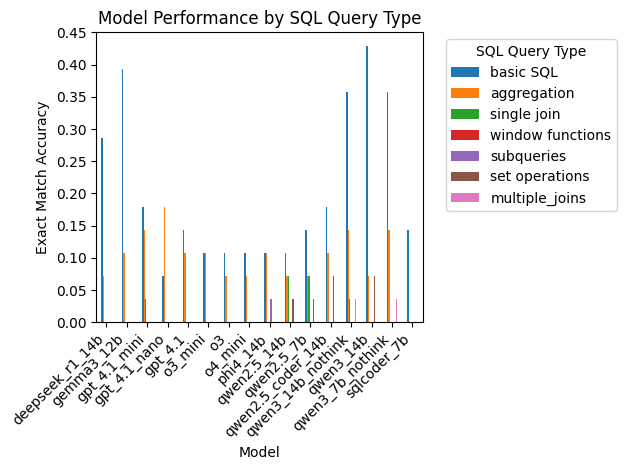

In [9]:
# Get unique SQL complexity types
sql_types = set()
for model in metrics.values():
    sql_types.update(model.per_sql_complexity_counts.keys())

# Create DataFrame for SQL complexity analysis
sql_complexity_data = []
for model_name in metrics.keys():
    model = metrics[model_name]
    row_data = {'Model': model_name}
    for sql_type in sql_types:
        row_data[sql_type] = model.accuracy_exact(sql_type)
    sql_complexity_data.append(row_data)

sql_complexity_df = pd.DataFrame(sql_complexity_data)

# Plot
plt.figure(figsize=(15, 8))
sql_complexity_df.set_index('Model').plot(kind='bar')
plt.title('Model Performance by SQL Query Type')
plt.xlabel('Model')
plt.ylabel('Exact Match Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='SQL Query Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

<Figure size 1500x800 with 0 Axes>

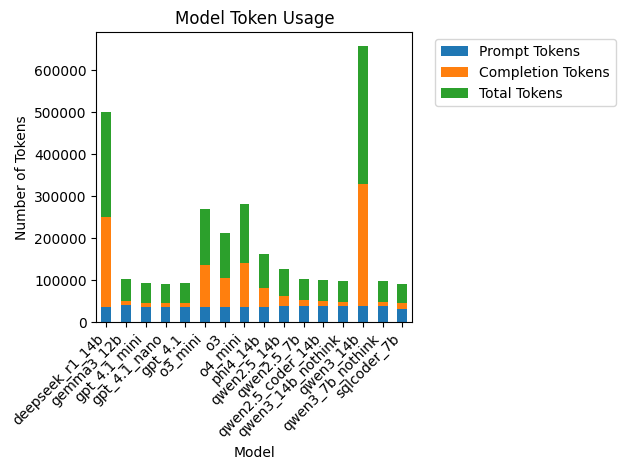

In [10]:
# Create DataFrame for token analysis
token_data = pd.DataFrame([
    {
        'Model': model_name,
        'Prompt Tokens': metrics[model_name].total_prompt_tokens,
        'Completion Tokens': metrics[model_name].total_completion_tokens,
        'Total Tokens': metrics[model_name].total_tokens
    }
    for model_name in metrics.keys()
])

# Plot
plt.figure(figsize=(15, 8))
token_data.set_index('Model').plot(kind='bar', stacked=True)
plt.title('Model Token Usage')
plt.xlabel('Model')
plt.ylabel('Number of Tokens')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()